## Import Libraries
Here, we import the necessary libraries for data processing and visualization.

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Define plot_all_channels Function
Define a function `plot_all_channels` that takes a DataFrame and a title as inputs, and creates a figure with subplots for each channel.

In [53]:
def plot_all_channels(df, title): # Create a figure and subplots for each channel
  fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 10), sharex=True)

  for i, channel in enumerate(selected_columns[:-1]):
      axes[i].plot(df[channel], label=channel)
      axes[i].set_ylabel(channel)
      axes[i].legend(loc="upper left")

  # Set the x-axis label and title for the entire figure
  plt.xlabel("Sample Index")
  plt.suptitle(title)

  # Display the plot
  plt.show()

## Load and Preprocess Data
Load the CSV data into a Pandas DataFrame, preprocess it by renaming columns, selecting specific columns, removing initial rows, and fixing timestamps.

In [54]:
# Update the file path below with the path to your CSV file
csv_file_path = "data.csv"

# Read the CSV data into a Pandas DataFrame, skipping the first 4 lines of metadata
df = pd.read_csv(csv_file_path, skiprows=4)

# Rename the columns by removing leading spaces
df.columns = [col.lstrip() for col in df.columns]

# Print the column names
print(df.columns)

Index(['Sample Index', 'EXG Channel 0', 'EXG Channel 1', 'EXG Channel 2',
       'EXG Channel 3', 'EXG Channel 4', 'EXG Channel 5', 'EXG Channel 6',
       'EXG Channel 7', 'Accel Channel 0', 'Accel Channel 1',
       'Accel Channel 2', 'Other', 'Other.1', 'Other.2', 'Other.3', 'Other.4',
       'Other.5', 'Other.6', 'Analog Channel 0', 'Analog Channel 1',
       'Analog Channel 2', 'Timestamp', 'Other.7', 'Timestamp (Formatted)'],
      dtype='object')


## Plot Raw EXG Channels
Plot the raw EXG channels using the `plot_all_channels` function.

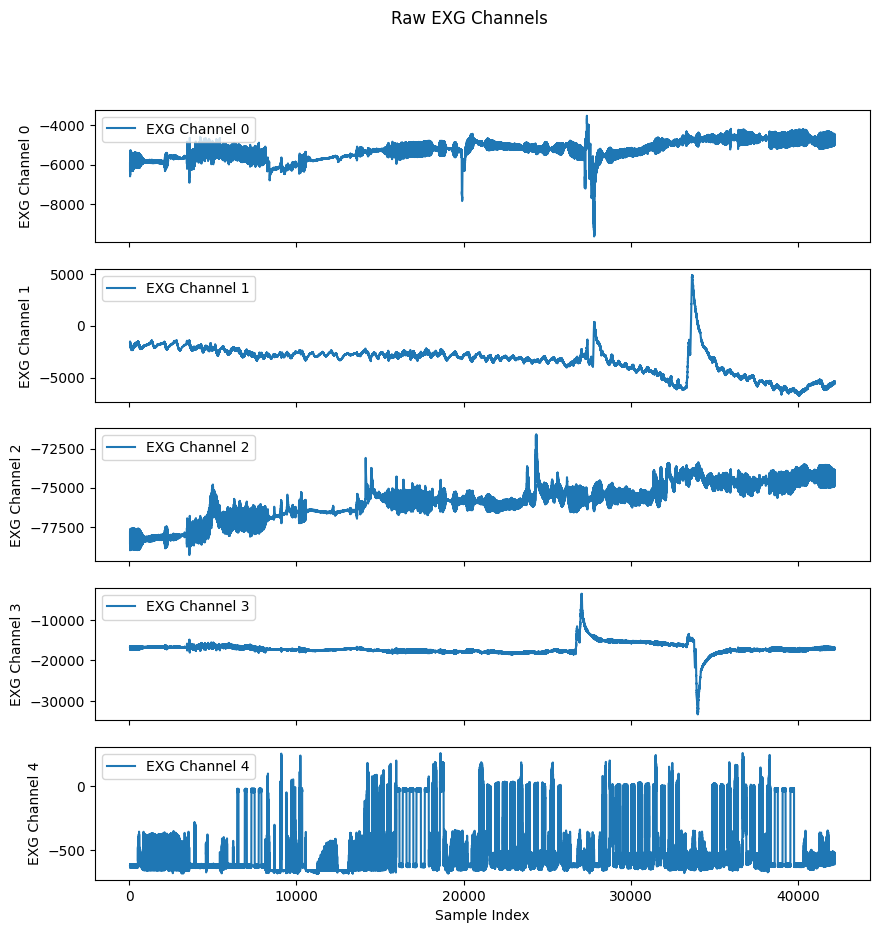

In [55]:
# Update the selected_columns variable with the correct column names
selected_columns = ["EXG Channel 0", "EXG Channel 1", "EXG Channel 2", "EXG Channel 3", "EXG Channel 4", "Timestamp (Formatted)"]
df = df[selected_columns]

# Remove first few rows
df = df.iloc[50:]

# Fix timestamps
df['Timestamp (Formatted)'] = pd.to_datetime(df['Timestamp (Formatted)'], format='%Y-%m-%d %H:%M:%S.%f')

# Plot
plot_all_channels(df, "Raw EXG Channels")

## Outliers Handling (Currently commented out)
Calculate the IQR and handle outliers for "EXG Channel 4" and other EXG channels. This section is commented out, so the original data is used for the following steps.

In [56]:
# # Calculate the IQR for "EXG Channel 4" column only
# Q1 = df["EXG Channel 4"].quantile(0.25)
# Q3 = df["EXG Channel 4"].quantile(0.75)
# IQR = Q3 - Q1

# # Identify outliers for "EXG Channel 4" column only
# upper_outliers = (df["EXG Channel 4"] > (Q3 + 1.5 * IQR))
# lower_outliers = (df["EXG Channel 4"] < (Q1 - 1.5 * IQR))

# # Replace outliers with the mean for "EXG Channel 4" column only
# df_fixed_labels = df.copy()  # Create a copy of the dataframe to not modify the original
# df_fixed_labels.loc[upper_outliers, "EXG Channel 4"] = df["EXG Channel 4"].max()
# df_fixed_labels.loc[lower_outliers, "EXG Channel 4"] = df["EXG Channel 4"].min()

# # Plot
# plot_all_channels(df_fixed_labels, "No Outliers in EXG Channel 4 - Replaced with max/min")

In [57]:
# OUTLIER_RANGE = 1.5

# # Calculate the IQR for each column, excluding "EXG Channel 4"
# Q1 = df_fixed_labels.drop(columns="EXG Channel 4").quantile(0.25)
# Q3 = df_fixed_labels.drop(columns="EXG Channel 4").quantile(0.75)
# IQR = Q3 - Q1

# # Identify outliers, excluding "EXG Channel 4"
# upper_outliers = (df_fixed_labels.drop(columns="EXG Channel 4") > (Q3 + OUTLIER_RANGE * IQR))
# lower_outliers = (df_fixed_labels.drop(columns="EXG Channel 4") < (Q1 - OUTLIER_RANGE * IQR))

# # Replace outliers with the mean, excluding "EXG Channel 4"
# df_no_outliers = df_fixed_labels.drop(columns="EXG Channel 4").mask(upper_outliers).apply(lambda x: x.fillna(x.max()), axis=0)
# df_no_outliers = df_fixed_labels.drop(columns="EXG Channel 4").mask(lower_outliers).apply(lambda x: x.fillna(x.min()), axis=0)

# # Add the "EXG Channel 4" column back to the DataFrame
# df_no_outliers["EXG Channel 4"] = df_fixed_labels["EXG Channel 4"]

# plot(df_no_outliers, "No Outliers in otherEXG Channels - Replaced with min/max")

In [58]:
df_no_outliers = df

## Data Normalization
Normalize the data using Min-Max normalization, round "EXG Channel 4" values to 0 or 1, and create a new DataFrame `df_normalized`.

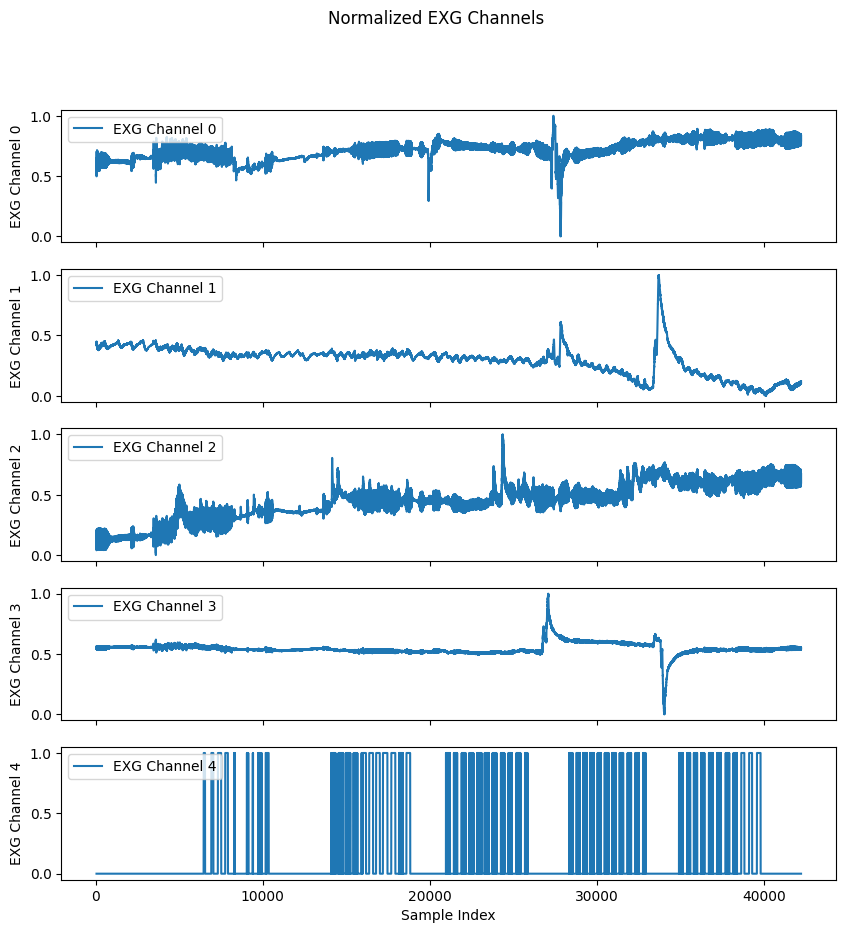

In [59]:
# Drop the "Timestamp (Formatted)" column
df_temp = df_no_outliers.drop('Timestamp (Formatted)', axis=1)

# Normalize the data using Min-Max normalization
df_normalized = (df_temp - df_temp.min()) / (df_temp.max() - df_temp.min())

# Round "EXG Channel 4" values to 0 or 1
df_normalized["EXG Channel 4"] = df_normalized["EXG Channel 4"].round()

# Add the "Timestamp (Formatted)" column back to the DataFrame
df_normalized['Timestamp (Formatted)'] = df_no_outliers['Timestamp (Formatted)']

# Plot
plot_all_channels(df_normalized, "Normalized EXG Channels")

## Add Rolling Max Column
Add a new column to the DataFrame `df_normalized` for the rolling maximum of "EXG Channel 4" with a window size of 90.

In [60]:
# Make rolling max column
df_normalized['rolling_max'] = df_normalized['EXG Channel 4'].rolling(window=90, center=True).max()

## Define plot_rolling_channel_4 and segment_stats Functions
Define two functions: `plot_rolling_channel_4` for plotting the rolling maximum of "EXG Channel 4" with different ranges, and `segment_stats` for calculating statistics about the segments.

In [61]:
def plot_rolling_channel_4(title, tick_gap = 2500, start=None, end=None, df = df_normalized):
  # Do proper data cut based on arguments
  if start is None and end is None:
    start = 0
    end = len(df)

  # Plot the original data and the rolling mean on a number line
  plt.figure(figsize=(16, 4))
  # plt.plot(df.index, df['EXG Channel 4'], label='Original Data', alpha=0.5)
  plt.plot(df[start:end].index, df['rolling_max'][start:end], linewidth=1)
  plt.xlabel('Index')
  plt.ylabel('EXG Channel 4')

  plt.xticks(list(range(start, end, tick_gap)))

  plt.title(title)
  plt.show()

def segment_stats(df, segments):
    # Calculate statistics about the list of segments
    num_segments = len(segments)  # Number of segments
    segment_lengths = [end - start for start, end in segments]  # Lengths of each segment in terms of indices

    # Calculate the average segment length
    average_length = np.around(np.mean(segment_lengths), 2)

    # Calculate the minimum and maximum segment length
    min_length = np.min(segment_lengths)
    max_length = np.max(segment_lengths)

    # Calculate the segment lengths in terms of time (milliseconds) using the "Timestamp" column
    segment_lengths_ms = [(df.loc[end, 'Timestamp (Formatted)'] - df.loc[start, 'Timestamp (Formatted)']).total_seconds() * 1000 for start, end in segments]

    # Calculate the mean, min, and max segment lengths in milliseconds
    mean_length_ms = np.around(np.mean(segment_lengths_ms), 2)
    min_length_ms = np.around(np.min(segment_lengths_ms), 2)
    max_length_ms = np.around(np.max(segment_lengths_ms), 2)

    # Print the statistics
    print(f"\nSegments: {segments}")
    print(f"Number of segments: {num_segments}")
    print(f"Average segment length: {average_length} values")
    print(f"Minimum segment length: {min_length} values")
    print(f"Maximum segment length: {max_length} values")
    print(f"Average segment length (ms): {mean_length_ms} ms")
    print(f"Minimum segment length (ms): {min_length_ms} ms")
    print(f"Maximum segment length (ms): {max_length_ms} ms")

## Identify Segments
Identify the start and end indices of segments with 1s in the rolling maximum of "EXG Channel 4".

In [62]:
# Add a new column to the dataframe to identify the change in segments between 0s and 1s
df_normalized['segment_change'] = df_normalized['rolling_max'].diff()

# Identify the start and end indices of the segments with 1s
start_indices = df_normalized[df_normalized['segment_change'] == 1].index.tolist()
end_indices = df_normalized[df_normalized['segment_change'] == -1].index.tolist()

# If the first segment starts with 1s, add the starting index to the list
first_index = df_normalized.index[0]  # Get the first index of the dataframe
if df_normalized.loc[first_index, 'rolling_max'] == 1:
    start_indices.insert(0, first_index)

# If the last segment ends with 1s, add the last index to the list
last_index = df_normalized.index[-1]  # Get the last index of the dataframe
if df_normalized.loc[last_index, 'rolling_max'] == 1:
    end_indices.append(last_index)

# Combine the start and end indices into pairs
segments = list(zip(start_indices, end_indices))

## Plot and Calculate Segment Statistics
Plot and analyze different segments of the data using the `plot_rolling_channel_4` and `segment_stats` functions.

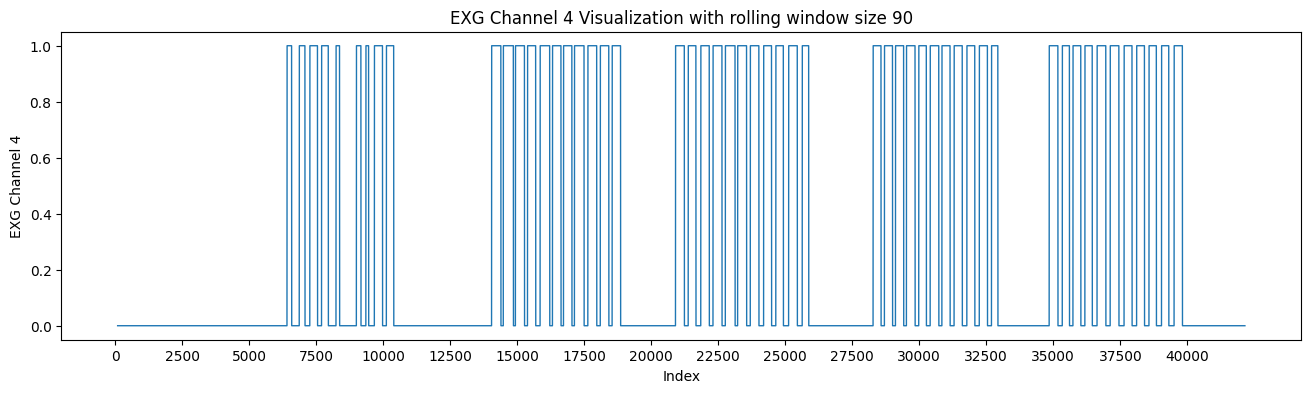


Segments: [(6413, 6585), (6870, 7082), (7264, 7550), (7702, 7953), (8241, 8373), (9001, 9170), (9355, 9457), (9672, 9975), (10120, 10393), (14045, 14391), (14482, 14857), (14934, 15271), (15385, 15689), (15855, 16212), (16316, 16633), (16728, 17040), (17136, 17494), (17636, 17966), (18100, 18417), (18542, 18856), (20906, 21235), (21380, 21667), (21849, 22165), (22305, 22639), (22765, 23127), (23224, 23557), (23696, 24016), (24193, 24488), (24648, 24929), (25126, 25449), (25633, 25874), (28277, 28572), (28700, 29001), (29112, 29416), (29521, 29842), (29980, 30263), (30407, 30727), (30844, 31148), (31299, 31603), (31775, 32070), (32239, 32542), (32694, 32931), (34846, 35171), (35335, 35601), (35733, 36025), (36178, 36452), (36632, 36958), (37122, 37446), (37640, 37936), (38108, 38400), (38569, 38844), (39037, 39307), (39506, 39815)]
Number of segments: 53
Average segment length: 292.53 values
Minimum segment length: 102 values
Maximum segment length: 375 values
Average segment length (m

In [63]:
plot_rolling_channel_4("EXG Channel 4 Visualization with rolling window size 90")
segment_stats(df_normalized, segments)

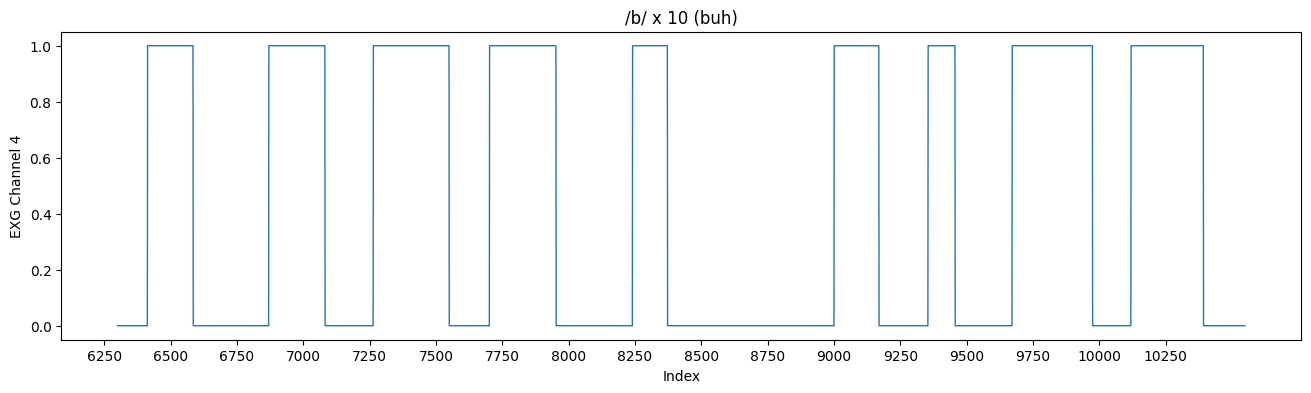


Segments: [(6413, 6585), (6870, 7082), (7264, 7550), (7702, 7953), (8241, 8373), (9001, 9170), (9355, 9457), (9672, 9975), (10120, 10393)]
Number of segments: 9
Average segment length: 211.11 values
Minimum segment length: 102 values
Maximum segment length: 303 values
Average segment length (ms): 844.33 ms
Minimum segment length (ms): 407.0 ms
Maximum segment length (ms): 1208.0 ms


In [64]:
plot_rolling_channel_4("/b/ x 10 (buh)", 250, 6250, 10500)
segment_stats(df_normalized, segments[0:9])

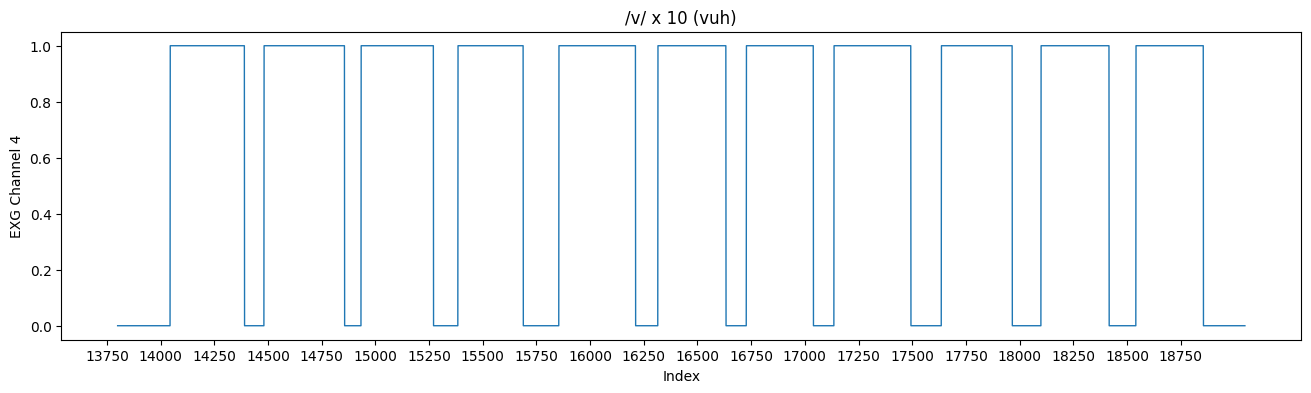


Segments: [(14045, 14391), (14482, 14857), (14934, 15271), (15385, 15689), (15855, 16212), (16316, 16633), (16728, 17040), (17136, 17494), (17636, 17966), (18100, 18417), (18542, 18856)]
Number of segments: 11
Average segment length: 333.36 values
Minimum segment length: 304 values
Maximum segment length: 375 values
Average segment length (ms): 1355.0 ms
Minimum segment length (ms): 1216.0 ms
Maximum segment length (ms): 1495.0 ms


In [65]:
plot_rolling_channel_4("/v/ x 10 (vuh)", 250, 13750, 19000)
segment_stats(df_normalized, segments[9:20])

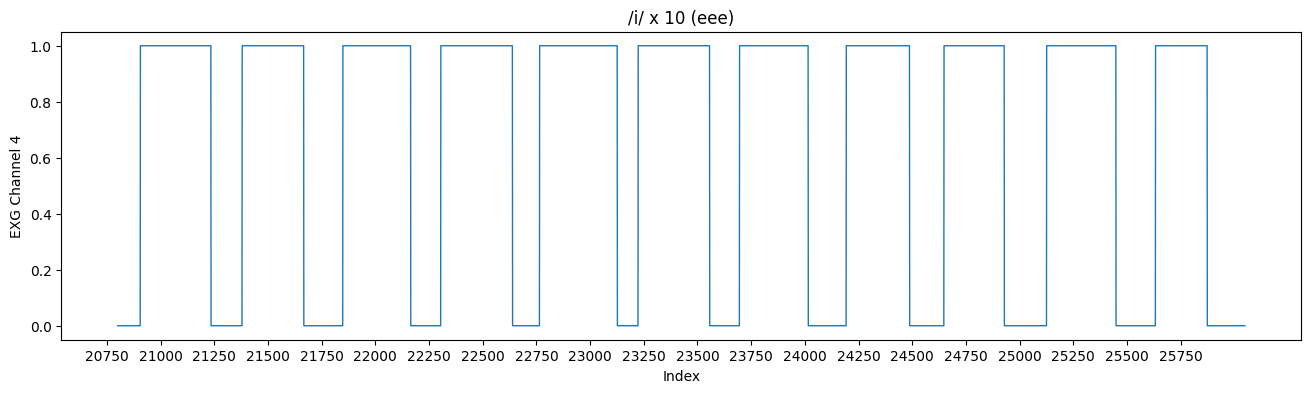


Segments: [(20906, 21235), (21380, 21667), (21849, 22165), (22305, 22639), (22765, 23127), (23224, 23557), (23696, 24016), (24193, 24488), (24648, 24929), (25126, 25449), (25633, 25874)]
Number of segments: 11
Average segment length: 311.0 values
Minimum segment length: 241 values
Maximum segment length: 362 values
Average segment length (ms): 1252.0 ms
Minimum segment length (ms): 962.0 ms
Maximum segment length (ms): 1444.0 ms


In [66]:
plot_rolling_channel_4("/i/ x 10 (eee)", 250, 20750, 26000)
segment_stats(df_normalized, segments[20:31])

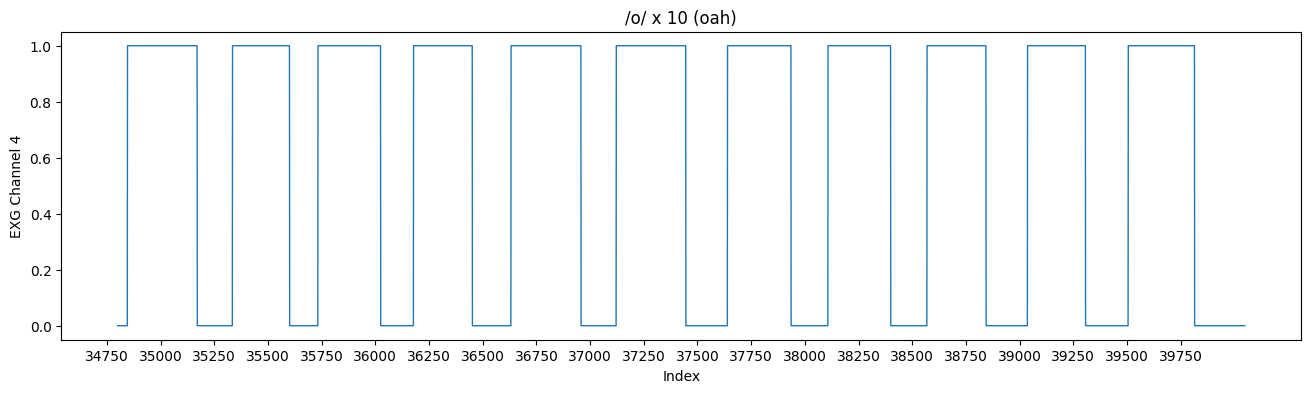


Segments: [(28277, 28572), (28700, 29001), (29112, 29416), (29521, 29842), (29980, 30263), (30407, 30727), (30844, 31148), (31299, 31603), (31775, 32070), (32239, 32542), (32694, 32931)]
Number of segments: 11
Average segment length: 297.0 values
Minimum segment length: 237 values
Maximum segment length: 321 values
Average segment length (ms): 1185.09 ms
Minimum segment length (ms): 938.0 ms
Maximum segment length (ms): 1280.0 ms


In [67]:
plot_rolling_channel_4("/o/ x 10 (oah)", 250, 34750, 40000)
segment_stats(df_normalized, segments[31:42])

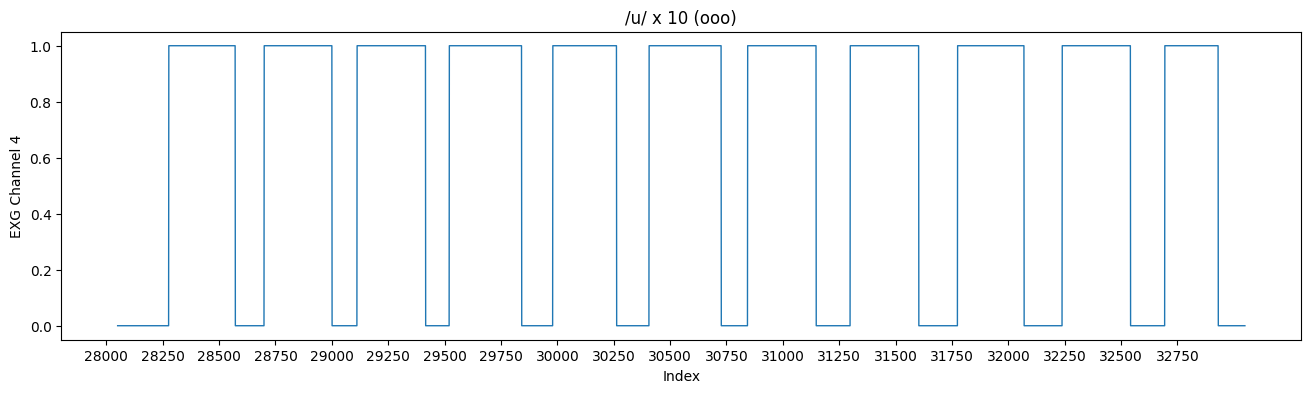


Segments: [(34846, 35171), (35335, 35601), (35733, 36025), (36178, 36452), (36632, 36958), (37122, 37446), (37640, 37936), (38108, 38400), (38569, 38844), (39037, 39307), (39506, 39815)]
Number of segments: 11
Average segment length: 295.36 values
Minimum segment length: 266 values
Maximum segment length: 326 values
Average segment length (ms): 1182.09 ms
Minimum segment length (ms): 1061.0 ms
Maximum segment length (ms): 1301.0 ms


In [68]:
plot_rolling_channel_4("/u/ x 10 (ooo)", 250, 28000, 33000)
segment_stats(df_normalized, segments[42:])